<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Comparison_of_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of activation functions
This notebooks compares different activations functions used in a simple 5-layer CNN for MNIST. For visualizing Integrated Gradients is used.

## Imports

In [7]:
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
!rm -r understanding_cnn

!git clone https://github.com/hiranumn/IntegratedGradients
if not os.path.isfile("IntegratedGradients.py"):
  shutil.move("/content/IntegratedGradients/IntegratedGradients.py", "/content")
!rm -r IntegratedGradients

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 313 (delta 41), reused 14 (delta 5), pack-reused 221
Receiving objects: 100% (313/313), 38.49 MiB | 40.22 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Cloning into 'IntegratedGradients'...
remote: Enumerating objects: 214, done.
remote: Total 214 (delta 0), reused 0 (delta 0), pack-reused 214
Receiving objects: 100% (214/214), 884.57 KiB | 6.80 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [0]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")
IntegratedGradients = imp.load_source("IntegratedGradients", "IntegratedGradients.py")

from IntegratedGradients import *

## Data
Load the MNIST dataset for training and analysis

In [39]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_train, y_train, x_test, y_test = data
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Extracting ../notebooks/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-labels-idx1-ubyte.gz


In [85]:
# MNIST DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../notebooks/MNIST_data/", one_hot=True)

X = np.expand_dims(mnist.train._images.reshape(55000,28, 28), 3)
Y = mnist.train._labels
X = np.expand_dims(mnist.test._images.reshape(10000,28, 28), 3)
Y = mnist.test._labels

Extracting ../notebooks/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../notebooks/MNIST_data/t10k-labels-idx1-ubyte.gz


## Models
Trains CNNs

In [0]:
activation_functions = ["relu","sigmoid","tanh"]

In [14]:
for activation_function in activation_functions:  
  batch_size = 128
  epochs = 15
  input_shape = (28, 28, 1)

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation=activation_function,
                   input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation=activation_function))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

  mcp_save = ModelCheckpoint('cnn_MNIST_'+activation_function+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[mcp_save],
            validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 8s 139us/step - loss: 0.2774 - acc: 0.9149 - val_loss: 0.0539 - val_acc: 0.9825
Epoch 2/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0993 - acc: 0.9697 - val_loss: 0.0389 - val_acc: 0.9871
Epoch 3/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0746 - acc: 0.9777 - val_loss: 0.0409 - val_acc: 0.9873
Epoch 4/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0603 - acc: 0.9821 - val_loss: 0.0329 - val_acc: 0.9888
Epoch 5/15
60000/60000 [==============================] - 4s 75us/step - loss: 0.0502 - acc: 0.9847 - val_loss: 0.0328 - val_acc: 0.9898
Epoch 6/15
60000/60000 [=====

In [83]:
from keras.layers import LeakyReLU

alpha = 0.3
batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(LeakyReLU(alpha))
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_MNIST_'+"LeakyReLU"+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))

Train on 55000 samples, validate on 10000 samples
Epoch 1/15
55000/55000 [==============================] - 9s 166us/step - loss: 0.2142 - acc: 0.9348 - val_loss: 2.1678 - val_acc: 0.7113
Epoch 2/15
55000/55000 [==============================] - 5s 92us/step - loss: 0.0816 - acc: 0.9757 - val_loss: 1.5596 - val_acc: 0.7861
Epoch 3/15
55000/55000 [==============================] - 5s 92us/step - loss: 0.0631 - acc: 0.9806 - val_loss: 0.8552 - val_acc: 0.8534
Epoch 4/15
55000/55000 [==============================] - 5s 89us/step - loss: 0.0546 - acc: 0.9822 - val_loss: 2.0358 - val_acc: 0.7422
Epoch 5/15
55000/55000 [==============================] - 5s 88us/step - loss: 0.0482 - acc: 0.9845 - val_loss: 0.6936 - val_acc: 0.8885
Epoch 6/15
55000/55000 [==============================] - 5s 88us/step - loss: 0.0416 - acc: 0.9865 - val_loss: 1.1919 - val_acc: 0.8388
Epoch 7/15
55000/55000 [==============================] - 5s 88us/step - loss: 0.0389 - acc: 0.9873 - val_loss: 0.7056 - val_ac

In [84]:
from keras.layers import PReLU

batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(PReLU())
model.add(Conv2D(64, (3, 3)))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(PReLU())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_MNIST_'+"PReLU"+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))

Train on 55000 samples, validate on 10000 samples
Epoch 1/15
55000/55000 [==============================] - 11s 201us/step - loss: 0.2416 - acc: 0.9257 - val_loss: 0.1039 - val_acc: 0.9672
Epoch 2/15
55000/55000 [==============================] - 7s 122us/step - loss: 0.0801 - acc: 0.9760 - val_loss: 0.1409 - val_acc: 0.9618
Epoch 3/15
55000/55000 [==============================] - 7s 122us/step - loss: 0.0579 - acc: 0.9821 - val_loss: 0.1427 - val_acc: 0.9614
Epoch 4/15
55000/55000 [==============================] - 7s 122us/step - loss: 0.0478 - acc: 0.9845 - val_loss: 0.1214 - val_acc: 0.9702
Epoch 5/15
55000/55000 [==============================] - 7s 122us/step - loss: 0.0394 - acc: 0.9877 - val_loss: 0.0981 - val_acc: 0.9773
Epoch 6/15
55000/55000 [==============================] - 7s 122us/step - loss: 0.0332 - acc: 0.9893 - val_loss: 0.1332 - val_acc: 0.9740
Epoch 7/15
55000/55000 [==============================] - 7s 121us/step - loss: 0.0319 - acc: 0.9900 - val_loss: 0.1410 -

## Analysis

In [0]:
model_file_names = ["cnn_MNIST_sigmoid_model.hdf5",
                    "cnn_MNIST_tanh_model.hdf5",
                    "cnn_MNIST_relu_model.hdf5",
                    "cnn_MNIST_LeakyReLU_model.hdf5",
                    "cnn_MNIST_PReLU_model.hdf5",
                   ]

In [91]:
n = 10
test_images = list(zip(X[:n], Y[:n]))

analysis = np.zeros([len(model_file_names),len(test_images),10,28,28,1])

for j,model_name in enumerate(model_file_names):
  print(model_name)
  model = load_model(model_name)
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  
  ig = integrated_gradients(model)  
  
  for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    #x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    #presm = model_wo_softmax.predict_on_batch(x)[0]
    #prob = model.predict_on_batch(x)[0]
    #y_hat = prob.argmax()
    
    for k in range(0,10):
      analysis[j,i,k] = ig.explain(x,outc=k)

cnn_MNIST_sigmoid_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_tanh_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_relu_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_LeakyReLU_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_PReLU_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


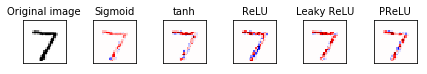

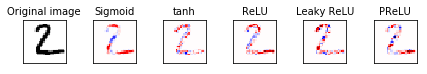

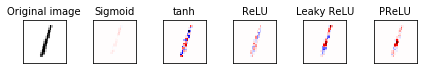

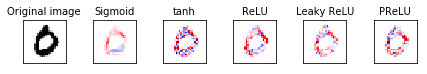

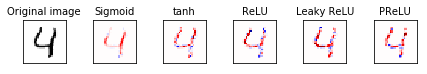

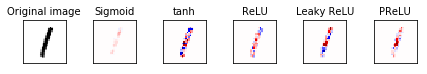

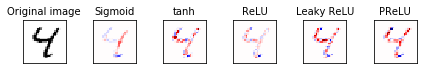

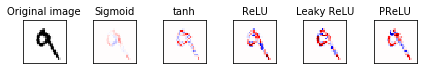

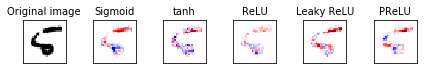

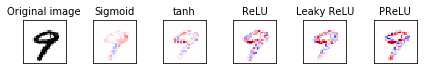

In [94]:
model_names = ["Sigmoid", "tanh", "ReLU", 
               "Leaky ReLU", "PReLU"
              ]

for j in range(len(test_images)):

  # Plot the true image.
  plt.figure()
  plt.subplot(1,6,1)
  plt.imshow(test_images[j][0].reshape((28,28)), cmap="Greys")
  plt.xticks([],[])
  plt.yticks([],[])
  plt.title("Original image", fontsize=10)

  for a in range(len(model_names)):
    # Generate explanation with respect to each of 10 output channels.
    exs = analysis[a,j,:,:,:,:]

    # Plot them
    th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
    plt.subplot(1,6,a+2)
    plt.imshow(exs[np.argmax(test_images[j][1])].reshape((28,28)), cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(model_names[a], fontsize=10)
  plt.tight_layout()
  #plt.savefig("../notebooks/figures/"+str(index)+".png")
  plt.show()